In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [2]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

In [3]:
%load_ext autoreload
%autoreload 2

In [4]:
# OK this might look a little ugly but...
# need to import the latest version of networkx
# This occassionally fails, so if the next cell 
# doesn't show that you're using networkx 2.1
# please "restart and clear output" from "Kernel" menu
# above and try again.
import sys
!{sys.executable} -m pip install -I networkx==2.1
import pkg_resources
pkg_resources.require("networkx==2.1")
import networkx as nx

  Using cached https://files.pythonhosted.org/packages/bc/bb/a24838832ba35baf52f32ab1a49b906b5f82fb7c76b2f6a7e35e140bac30/decorator-4.3.0-py2.py3-none-any.whl
You are using pip version 9.0.3, however version 10.0.1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


In [5]:
nx.__version__

'2.1'

In [6]:
import argparse
import time
import msgpack
from enum import Enum, auto

import numpy as np
import numpy.linalg as LA

from voxmap import create_voxmap
from planning_utils import a_star, heuristic, create_grid
from planning_utils import create_grid_and_edges, a_star_graph
from udacidrone import Drone
from udacidrone.connection import MavlinkConnection
from udacidrone.messaging import MsgID
from udacidrone.frame_utils import global_to_local

In [7]:
import matplotlib.pyplot as plt

%matplotlib inline
plt.rcParams['figure.figsize'] = 12, 12

In [8]:
class States(Enum):
    MANUAL = auto()
    ARMING = auto()
    TAKEOFF = auto()
    WAYPOINT = auto()
    LANDING = auto()
    DISARMING = auto()
    PLANNING = auto()

In [9]:
class MotionPlanning(Drone):

    def __init__(self, connection):
        super().__init__(connection)

        self.target_position = np.array([0.0, 0.0, 0.0])
        self.waypoints = []
        self.in_mission = True
        self.check_state = {}

        # initial state
        self.flight_state = States.MANUAL
        
        self.GRD = None

        # register all your callbacks here
        self.register_callback(MsgID.LOCAL_POSITION, self.local_position_callback)
        self.register_callback(MsgID.LOCAL_VELOCITY, self.velocity_callback)
        self.register_callback(MsgID.STATE, self.state_callback)

    def local_position_callback(self):
        if self.flight_state == States.TAKEOFF:
            if -1.0 * self.local_position[2] > 0.95 * self.target_position[2]:
                self.waypoint_transition()
        elif self.flight_state == States.WAYPOINT:
            if np.linalg.norm(self.target_position[0:2] - self.local_position[0:2]) < 1.0:
                if len(self.waypoints) > 0:
                    self.waypoint_transition()
                else:
                    if np.linalg.norm(self.local_velocity[0:2]) < 1.0:
                        self.landing_transition()

    def velocity_callback(self):
        if self.flight_state == States.LANDING:
            if self.global_position[2] - self.global_home[2] < 0.1:
                if abs(self.local_position[2]) < 0.01:
                    self.disarming_transition()

    def state_callback(self):
        if self.in_mission:
            if self.flight_state == States.MANUAL:
                self.arming_transition()
            elif self.flight_state == States.ARMING:
                if self.armed:
                    self.plan_path()
            elif self.flight_state == States.PLANNING:
                self.takeoff_transition()
            elif self.flight_state == States.DISARMING:
                if ~self.armed & ~self.guided:
                    self.manual_transition()

    def arming_transition(self):
        self.flight_state = States.ARMING
        print("arming transition")
        self.arm()
        self.take_control()

    def takeoff_transition(self):
        self.flight_state = States.TAKEOFF
        print("takeoff transition")
        self.takeoff(self.target_position[2])

    def waypoint_transition(self):
        self.flight_state = States.WAYPOINT
        print("waypoint transition")
        self.target_position = self.waypoints.pop(0)
        print('target position', self.target_position)
        self.cmd_position(self.target_position[0], self.target_position[1], self.target_position[2], self.target_position[3])

    def landing_transition(self):
        self.flight_state = States.LANDING
        print("landing transition")
        self.land()

    def disarming_transition(self):
        self.flight_state = States.DISARMING
        print("disarm transition")
        self.disarm()
        self.release_control()

    def manual_transition(self):
        self.flight_state = States.MANUAL
        print("manual transition")
        self.stop()
        self.in_mission = False

    def send_waypoints(self):
        print("Sending waypoints to simulator ...")
        data = msgpack.dumps(self.waypoints)
        self.connection._master.write(data)

    def plan_path(self):
        self.flight_state = States.PLANNING
        print("Searching for a path ...")
        TARGET_ALTITUDE = 5
        SAFETY_DISTANCE = 5

        self.target_position[2] = TARGET_ALTITUDE

        # TODO: read lat0, lon0 from colliders into floating point values
        
        # TODO: set home position to (lon0, lat0, 0)

        # TODO: retrieve current global position
 
        # TODO: convert to current local position using global_to_local()
        
        print('global home {0}, position {1}, local position {2}'.format(self.global_home, self.global_position,
                                                                         self.local_position))
        # Read in obstacle map
        data = np.loadtxt('colliders.csv', delimiter=',', dtype='Float64', skiprows=2)
        
        # Define a grid for a particular altitude and safety margin around obstacles
        grid, north_offset, east_offset = create_grid(data, TARGET_ALTITUDE, SAFETY_DISTANCE)
        print("North offset = {0}, east offset = {1}".format(north_offset, east_offset))
        # Define starting point on the grid (this is just grid center)
        grid_start = (-north_offset, -east_offset)
        # TODO: convert start position to current position rather than map center
        
        # Set goal as some arbitrary position on the grid
        grid_goal = (-north_offset + 10, -east_offset + 10)
        # TODO: adapt to set goal as latitude / longitude position and convert

        # Run A* to find a path from start to goal
        # TODO: add diagonal motions with a cost of sqrt(2) to your A* implementation
        # or move to a different search space such as a graph (not done here)
        print('Local Start and Goal: ', grid_start, grid_goal)
        path, _ = a_star(grid, heuristic, grid_start, grid_goal)
        # TODO: prune path to minimize number of waypoints
        # TODO (if you're feeling ambitious): Try a different approach altogether!

        # Convert path to waypoints
        waypoints = [[p[0] + north_offset, p[1] + east_offset, TARGET_ALTITUDE, 0] for p in path]
        # Set self.waypoints
        self.waypoints = waypoints
        # TODO: send waypoints to sim (this is just for visualization of waypoints)
        self.send_waypoints()

    def start(self):
        self.start_log("Logs", "NavLog.txt")

        print("starting connection")
        self.connection.start()

        # Only required if they do threaded
        # while self.in_mission:
        #    pass

        self.stop_log()

In [10]:
def main():
    print("main")
    #parser = argparse.ArgumentParser()
    #parser.add_argument('--port', type=int, default=5760, help='Port number')
    #parser.add_argument('--host', type=str, default='127.0.0.1', help="host address, i.e. '127.0.0.1'")
    #args = parser.parse_args()

    conn = MavlinkConnection('tcp:{0}:{1}'.format('127.0.0.1', 5760), timeout=60)
    drone = MotionPlanning(conn)
    time.sleep(1)

    drone.start()

In [11]:
from planning_utils import a_star

In [12]:
def plot(grid, start_ne, goal_ne, goal_list=None, path=None):
    plt.figure(figsize=(24, 12))
    plt.imshow(grid, cmap='Greys', origin='lower')
    
    # For the purposes of the visual the east coordinate lay along
    # the x-axis and the north coordinates long the y-axis.
    plt.plot(start_ne[1], start_ne[0], 'gx', markersize=5, markeredgewidth=5)
    plt.plot(goal_ne[1], goal_ne[0], 'rx', markersize=5, markeredgewidth=5)
    
    for g in goal_list:
        plt.plot(g[1], g[0], 'bo', markeredgewidth=2)

    if path is not None:
        pp = np.array(path)
        #pp = np.array(parr)
        plt.plot(pp[:, 1], pp[:, 0], 'g')

    plt.xlabel('EAST')
    plt.ylabel('NORTH')
    plt.show()    

In [13]:
def plotgraph(grid, edges, start_ne, goal_ne, goal_list=None, path=None):
    plt.figure(figsize=(24, 12))
    plt.imshow(grid, origin='lower', cmap='Greys') 

    for e in edges:
        p1 = e[0]
        p2 = e[1]
        plt.plot([p1[1], p2[1]], [p1[0], p2[0]], 'b-')

    plt.plot(start_ne[1], start_ne[0], 'gx', markersize=5, markeredgewidth=5)
    plt.plot(goal_ne[1], goal_ne[0], 'rx', markersize=5, markeredgewidth=5)
    
    for g in goal_list:
        plt.plot(g[1], g[0], 'bo', markeredgewidth=2)

    if path is not None:
        pp = np.array(path)
        #pp = np.array(parr)
        plt.plot(pp[:, 1], pp[:, 0], 'g')    

    plt.xlabel('EAST')
    plt.ylabel('NORTH')
    plt.show()

In [14]:
def plotgraph2(grid, edges, start_ne, goal_ne, goal_list=None, path=None):
    plt.figure(figsize=(24, 12))
    plt.imshow(grid, origin='lower', cmap='Greys') 

    for e in edges:
        p1 = e[0]
        p2 = e[1]
        plt.plot([p1[1], p2[1]], [p1[0], p2[0]], 'b-')

    for g in goal_list:
        plt.plot(g[1], g[0], 'bo', markeredgewidth=2)
        
    plt.plot(start_ne[1], start_ne[0], 'gx', markersize=5, markeredgewidth=5)
    plt.plot(goal_ne[1], goal_ne[0], 'rx', markersize=5, markeredgewidth=5)
    
    real_cost = 0
    for i in range(len(path)-1):
        p1 = path[i]
        p2 = path[i+1]
        plt.plot([p1[1], p2[1]], [p1[0], p2[0]], 'r-')
        real_cost += LA.norm(np.array(p1) - np.array(p2))
    
    print("real_cost:", real_cost)
    plt.xlabel('EAST', fontsize=20)
    plt.ylabel('NORTH', fontsize=20)
    plt.show()

In [15]:
# Graph specific
def convert_graph(edges):
    G = nx.Graph()
    for e in edges:
        p1 = e[0]
        p2 = e[1]
        dist = LA.norm(np.array(p2) - np.array(p1))
        G.add_edge(p1,p2,weight=dist)
    return G

In [16]:
# Graph specific
def closest_point(graph, current_point):
    """
    Compute the closest point in the `graph`
    to the `current_point`.
    """
    closest_point = None
    dist = 100000
    for p in graph.nodes:
        d = LA.norm(np.array(p) - np.array(current_point))
        if d < dist:
            closest_point = p
            dist = d
    return closest_point

In [17]:
def point(p):
    return np.array([p[0], p[1], 1.]).reshape(1, -1)

def collinearity_check(p1, p2, p3, epsilon=1e-6):   
    m = np.concatenate((p1, p2, p3), 0)
    det = np.linalg.det(m)
    return abs(det) < epsilon

def prune_path(path):
    pruned_path = [p for p in path]
    # TODO: prune the path!
    i = 0
    while i < len(pruned_path) - 2:
        p1 = point(pruned_path[i])
        p2 = point(pruned_path[i+1])
        p3 = point(pruned_path[i+2])
        if collinearity_check(p1,p2,p3):
            pruned_path.remove(pruned_path[i+1])
        else:
            i += 1
    return pruned_path

In [18]:
class Grid():
    def __init__(self, TARGET_ALTITUDE, SAFETY_DISTANCE):
        # Read in obstacle map
        data = np.loadtxt('colliders.csv', delimiter=',', dtype='Float64', skiprows=2)
        grid, edges, north_offset, east_offset = create_grid_and_edges(data, TARGET_ALTITUDE, SAFETY_DISTANCE)
        print("grid# = {0}, edge# = {1}".format(len(grid), len(edges)))
        print("North offset = {0}, east offset = {1}".format(north_offset, east_offset))
        # Define starting point on the grid (this is just grid center)
        with open('colliders.csv') as f:
            first_line = f.readline().strip()
        latlon = first_line.split(',')
        self.lon0 = float(latlon[0].strip().split(' ')[1])
        self.lat0 = float(latlon[1].strip().split(' ')[1])      
        #grid_start = (-north_offset, -east_offset)
        # TODO: convert start position to current position rather than map center
        #self.set_home_position(lat0, lon0, 0)

        self.grid = grid
        self.edges = edges
        self.north_offset = north_offset
        self.east_offset = east_offset

main
Logs/TLog.txt
Logs/NavLog.txt
starting connection
arming transition
Searching for a path ...
global home [-122.3974533   37.7924804    0.       ], position [-122.3974509   37.7924818    0.184    ], local position [ 0.12449047  0.23997548 -0.18084516]
grid# = 921, edge# = 1419
North offset = -316, east offset = -445
lp: [ 0.15669141  0.21030786 -0.184     ]
gsf:  316.15669141244143 445.21030785527546
gs:  (316, 445)
change [0.10842096 0.07169301 0.41204401]
goal:  (-122.39734247903914, 37.79255349301069, 4.304440124329718)
lg:  [ 8.17253654  9.70499969 -4.30444012]
ggf:  324.1725365445018 454.7049996915739
455 920
gg:  (324, 455) 0.0
gg:  (324, 455)
Local Start and Goal:  (316, 445) (324, 455)


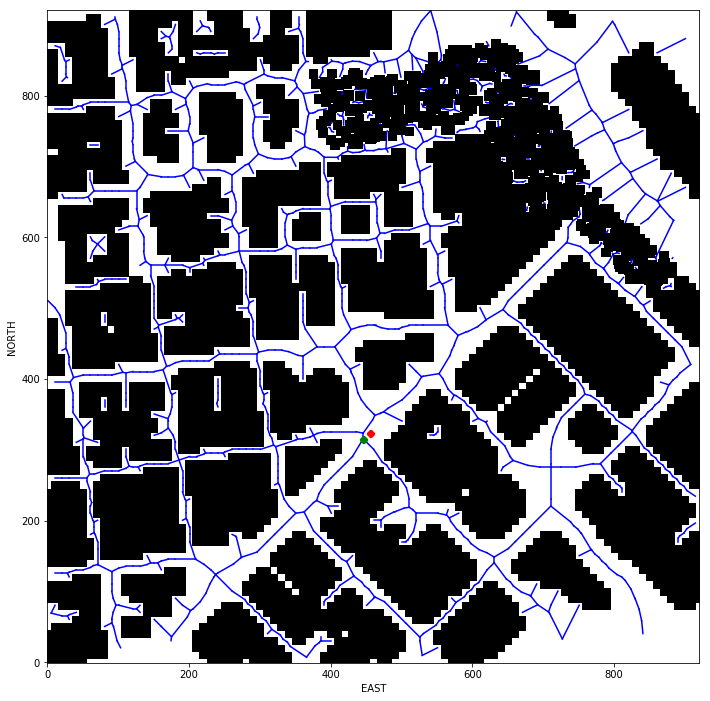

start_ne_g (315.76114, 445.76846)
goal_ne_g (323.76114, 445.76846)
takeoff transition


Traceback (most recent call last):
  File "/dd/env/fcnd/lib/python3.6/site-packages/udacidrone/drone.py", line 278, in notify_callbacks
    fn()
  File "<ipython-input-9-c75408979e95>", line 45, in state_callback
    self.plan_path()
  File "<ipython-input-19-db6552df1743>", line 124, in plan_path
    path, cost = a_star_graph(graph, heuristic, grid_start, grid_goal)
  File "/dd/D/Udacity/FCDN/Term1/10_MotionPlanning/FCND-Motion-Planning/planning_utils.py", line 639, in a_star_graph
    for next_node in graph[current_node]:
  File "/dd/env/fcnd/lib/python3.6/site-packages/networkx/classes/graph.py", line 440, in __getitem__
    return self.adj[n]
  File "/dd/env/fcnd/lib/python3.6/site-packages/networkx/classes/coreviews.py", line 82, in __getitem__
    return AtlasView(self._atlas[name])
KeyError: (316, 445)


waypoint transition


Traceback (most recent call last):
  File "/dd/env/fcnd/lib/python3.6/site-packages/udacidrone/drone.py", line 278, in notify_callbacks
    fn()
  File "<ipython-input-9-c75408979e95>", line 24, in local_position_callback
    self.waypoint_transition()
  File "<ipython-input-9-c75408979e95>", line 66, in waypoint_transition
    self.target_position = self.waypoints.pop(0)
IndexError: pop from empty list


landing transition
disarm transition
manual transition
Closing connection ...


In [19]:
def plan_path(self):
    self.flight_state = States.PLANNING
    print("Searching for a path ...")
    TARGET_ALTITUDE = 5
    SAFETY_DISTANCE = 5

    self.target_position[2] = TARGET_ALTITUDE

    # TODO: read lat0, lon0 from colliders into floating point values

    # TODO: set home position to (lon0, lat0, 0)

    # TODO: retrieve current global position

    # TODO: convert to current local position using global_to_local()

    print('global home {0}, position {1}, local position {2}'.format(self.global_home, self.global_position,
                                                                     self.local_position))
    # Read in obstacle map
    #data = np.loadtxt('colliders.csv', delimiter=',', dtype='Float64', skiprows=2)
    #voxmap = create_voxmap(data, 1)
    # Define a grid for a particular altitude and safety margin around obstacles
    #grid, north_offset, east_offset = create_grid(data, TARGET_ALTITUDE, SAFETY_DISTANCE)
    #grid, edges, north_offset, east_offset = create_grid_and_edges(data, TARGET_ALTITUDE, SAFETY_DISTANCE)
    #print("grid# = {0}, edge# = {1}".format(len(grid), len(edges)))
    #print("North offset = {0}, east offset = {1}".format(north_offset, east_offset))

    # Define starting point on the grid (this is just grid center)
    #with open('colliders.csv') as f:
    #    first_line = f.readline().strip()
    #latlon = first_line.split(',')
    #lon0 = float(latlon[0].strip().split(' ')[1])
    #lat0 = float(latlon[1].strip().split(' ')[1])      
    #grid_start = (-north_offset, -east_offset)
    # TODO: convert start position to current position rather than map center
    
    if self.GRD is None:
        self.GRD = Grid(TARGET_ALTITUDE, SAFETY_DISTANCE)
    grid = self.GRD.grid
    edges = self.GRD.edges
    north_offset = self.GRD.north_offset
    east_offset = self.GRD.east_offset
    lon0 = self.GRD.lon0
    lat0 = self.GRD.lat0
    
    self.set_home_position(lat0, lon0, 0)
#     print((lon0, lat0), " vs ", (-north_offset, -east_offset))    
#     print("lla: ",self._latitude, self._longitude, self._altitude)
#     print("gh: ",self.global_home)
#     print("gp: ",self.global_position)
    local_pos = global_to_local(self.global_position, global_home=self.global_home)
    print("lp:", local_pos)
    north, east, att = local_pos
    print("gsf: ", (north - north_offset), (east - east_offset))
    #3d
    #grid_start = (int(np.rint(north - north_offset)), int(np.rint(east - east_offset)), int(np.rint(self.global_position[2])))
    #2d
    grid_start = (int(np.rint(north - north_offset)), int(np.rint(east - east_offset)))
    print("gs: ",grid_start)
    

    
    # Set goal as some arbitrary position on the grid
    #grid_goal = (-north_offset + 10, -east_offset + 10)
    # TODO: adapt to set goal as latitude / longitude position and convert
    # grid_goal = (grid_start[0] + 10, grid_start[1] + 10)
    #goal = (-122.400600, 37.793401, 0)
    #goal = (lat0 + 0.0001, lon0 + 0.00001, 0)
    dist_idx = 1000.0
    goal_obs = True
    goal_try = 0
    goal_list = []
    grid_shape = grid.shape
    while goal_obs and goal_try < 100:
        goal_try += 1
        change = np.random.rand(3)
        change -= 0.5
        print("change", change)
        goal = (self.global_position[0] + change[0] / dist_idx,
                self.global_position[1] + change[1] / (dist_idx),
                self.global_position[2] + change[2] * 10.0)
        print("goal: ", goal)
        local_goal = global_to_local(goal, global_home=self.global_home)
        print("lg: ", local_goal)
        ng, eg, ag = local_goal
        print("ggf: ", (ng - north_offset), (eg - east_offset))
        #3d
        #grid_goal = (int(np.rint(ng - north_offset)), int(np.rint(eg - east_offset)), int(np.rint(goal[2])))
        #2d
        grid_goal = (int(np.rint(ng - north_offset)), int(np.rint(eg - east_offset)))
        print(grid_goal[1], grid_shape[1] - 1)
        if grid_goal[0] >= grid_shape[0]:
            grid_goal = (grid_shape[0] - 1, grid_goal[1])
        elif grid_goal[0] < 0:
            grid_goal = (0, grid_goal[1])            
        if grid_goal[1] >= grid_shape[1]:
            grid_goal = (grid_goal[0], grid_shape[1] - 1)
        elif grid_goal[1] < 0:
            grid_goal = (grid_goal[0], 0)            
                    
        goal_obs = grid[grid_goal[0], grid_goal[1]]
        print("gg: ",grid_goal, goal_obs)
        if goal_obs:
            goal_list.append(grid_goal)
    
    #grid_goal = (grid_start[0] + 10, grid_start[1] + 10,0)    
    print("gg: ",grid_goal)
    # Run A* to find a path from start to goal
    # TODO: add diagonal motions with a cost of sqrt(2) to your A* implementation
    # or move to a different search space such as a graph (not done here)
    print('Local Start and Goal: ', grid_start, grid_goal)
    plotgraph(grid, edges, grid_start, grid_goal, goal_list=goal_list)
    #3d
    #path, _ = a_star(voxmap, heuristic, grid_start, grid_goal)
    #2d
    
    graph = convert_graph(edges)
    start_ne_g = closest_point(graph, grid_start)
    goal_ne_g = closest_point(graph, grid_goal)
    print("start_ne_g", start_ne_g)
    print("goal_ne_g", goal_ne_g)
    
    
    path, cost = a_star_graph(graph, heuristic, grid_start, grid_goal)
    print(len(path), cost)
    #plot(grid, grid_start, grid_goal, goal_list=[], path=path)
    plotgraph2(grid, edges, grid_start, grid_goal, goal_list=goal_list, path=path)
    plotgraph(grid, edges, grid_start, grid_goal, goal_list=goal_list, path=path)
    
    pruned_path = prune_path(path)
    print(len(pruned_path))
    #plot(grid, grid_start, grid_goal, goal_list=[], path=pruned_path)
    plotgraph2(grid, edges, grid_start, grid_goal, goal_list=goal_list, path=pruned_path)
    plotgraph(grid, edges, grid_start, grid_goal, goal_list=goal_list, path=pruned_path)
        
    print("A* path:")
    for p in path:
        print(p)
        
    print("Pruned_path:")
    for p in pruned_path:
        print(p)
    #    print(p, p.cost, p.delta, (p.delta[0] + north_offset, p.delta[1] + east_offset, TARGET_ALTITUDE, 0))
    # TODO: prune path to minimize number of waypoints
    # TODO (if you're feeling ambitious): Try a different approach altogether!

    # Convert path to waypoints
    #waypoints = [[p[0] + north_offset, p[1] + east_offset, TARGET_ALTITUDE, 0] for p in path]
    waypoints = [[p[0] + north_offset, p[1] + east_offset, TARGET_ALTITUDE, 0] for p in pruned_path]
    
    # Set self.waypoints
    self.waypoints = waypoints
    # TODO: send waypoints to sim (this is just for visualization of waypoints)
    self.send_waypoints()
MotionPlanning.plan_path = plan_path
main()

In [ ]:
main()

main
Logs/TLog.txt
Logs/NavLog.txt
starting connection
arming transition
Searching for a path ...
global home [-122.3974533   37.7924804    0.       ], position [-1.22397449e+02  3.77924838e+01  7.10000000e-02], local position [ 0.37621963  0.35888401 -0.06900144]


In [ ]:
data = np.loadtxt('colliders.csv', delimiter=',', dtype='Float64', skiprows=2)

In [ ]:
data = np.loadtxt('colliders.csv', delimiter=',', dtype='Float64', skiprows=0)

In [ ]:
#first_line = ""
with open('colliders.csv') as f:
    first_line = f.readline().strip()
print(first_line)    
latlon = first_line.split(',')
gs = float(latlon[0].strip().split(' ')[1])
ge = float(latlon[1].strip().split(' ')[1])
print(gs, ge)

In [ ]:
print(first_line.strip())